<div style="position: absolute; top: 0; left: 0; font-family: 'Garamond'; font-size: 16px;">
    <a href="https://github.com/patriciaapenat" style="text-decoration: none; color: inherit;">Patricia Peña Torres</a>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 48px;">
    <strong>Proyecto final, BRFSS-clustering</strong>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 36px;">
    <strong>5. Aplicación de algoritmos de clustering</strong>
</div>

__________________

<div style="font-family: 'Garamond'; font-size: 14px;">

El siguiente cuaderno de Jupyter está diseñado para llevar a cabo un análisis de agrupamiento de datos utilizando PySpark y TensorFlow. En él, se configura el entorno, se carga y prepara un conjunto de datos, se entrena un autoencoder para aprender representaciones eficientes de los datos, se aplica el algoritmo K-Means para realizar el clustering en las representaciones codificadas, y finalmente, se evalúan los resultados del clustering. Este cuaderno sirve como ejemplo de cómo combinar diversas herramientas y técnicas para realizar un análisis completo de agrupamiento de datos en un entorno de programación interactivo.
    
</div>

<div style="font-family: 'Garamond'; font-size: 14px;">
    
## Configuración del entorno de trabajo

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, Imputer
from scipy.spatial import KDTree
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import pandas as pd
import random
import os.path
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.linalg import Vectors
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from pyspark import SparkConf, SparkContext
from sklearn.preprocessing import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
import seaborn as sns
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from sklearn.cluster import KMeans as SKLearnKMeans

from functools import reduce

# Ignorar advertencias deprecated
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# configurar gráficos
sns.set(style="whitegrid", context="notebook", palette="mako")

<div style="font-family: 'Garamond'; font-size: 14px;">
    
### Configuración de Spark

In [3]:
# Si hay un SparkContext existente, debemos cerrarlo antes de crear uno nuevo
if 'sc' in locals() and sc:
    sc.stop()  # Detener el SparkContext anterior si existe

# Configuración de Spark
conf = (
    SparkConf()
    .setAppName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .setMaster("local[2]")  # Modo local con un hilo para ejecución
    .set("spark.driver.host", "127.0.0.1")  # Dirección del host del driver
    .set("spark.executor.heartbeatInterval", "3600s")  # Intervalo de latido del executor
    .set("spark.network.timeout", "7200s")  # Tiempo de espera de la red
    .set("spark.executor.memory", "14g")  # Memoria asignada para cada executor
    .set("spark.driver.memory", "14g")  # Memoria asignada para el driver
)

# Crear un nuevo SparkContext con la configuración especificada
sc = SparkContext(conf=conf)

# Configuración de SparkSession (interfaz de alto nivel para trabajar con datos estructurados en Spark)
spark = (
    SparkSession.builder
    .appName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .config("spark.sql.repl.eagerEval.enabled", True)  # Habilitar la evaluación perezosa en Spark SQL REPL
    .config("spark.sql.repl.eagerEval.maxNumRows", 1000)  # Número máximo de filas a mostrar en la evaluación perezosa
    .getOrCreate()  # Obtener la sesión Spark existente o crear una nueva si no existe
) 

<div style="font-family: 'Garamond'; font-size: 14px;">
    
### Lectura del archivo

In [4]:
df = spark.read.format("csv").option("header", "true").load(r"C:\\Users\\patri\\OneDrive - UAB\\Documentos\\GitHub\\BRFSS-clustering\\datos\\BRFSS_imputated_2022.csv")

In [5]:
# Convertir todas las columnas a tipo numérico
for column_name in df.columns:
    df = df.withColumn(column_name, col(column_name).cast("double"))

<div style="font-family: 'Garamond'; font-size: 14px;">

# Autoencoder


El autoencoder es una red neuronal artificial que se utiliza en tareas de aprendizaje no supervisado, y su función principal es aprender una representación comprimida de los datos de entrada. Esta representación comprimida, a menudo llamada "código" o "embedding", captura las características más importantes y relevantes de los datos originales. En el contexto de K-Means, el autoencoder se utiliza como un paso previo para mejorar la calidad de la representación de los datos antes de aplicar K-Means para la asignación de etiquetas a los clusters.

El proceso general implica dos etapas:

1. **Entrenamiento del Autoencoder**: Durante esta etapa, el autoencoder se entrena para aprender a comprimir y luego reconstruir los datos originales. El objetivo es minimizar la diferencia entre los datos de entrada y los datos reconstruidos, lo que lleva a la captura de patrones significativos en los datos y a una representación más eficiente. El resultado es una representación comprimida de los datos en un espacio de menor dimensionalidad.

2. **Aplicación de K-Means en la Representación Comprimida**: Una vez que se ha entrenado el autoencoder, la representación comprimida se utiliza como entrada para el algoritmo K-Means. K-Means agrupará los datos en clusters en función de esta representación, lo que puede ser más efectivo que aplicar K-Means directamente a los datos originales de alta dimensionalidad. Los clusters resultantes se utilizan como etiquetas para asignar las instancias de datos a grupos similares.

Este enfoque de preprocesamiento con un autoencoder puede ser beneficioso cuando se trabaja con datos de alta dimensionalidad, ruidosos o con características irrelevantes. Al reducir la dimensionalidad y mejorar la representación de los datos, se espera que K-Means produzca agrupamientos más significativos y efectivos en el espacio de la representación comprimida, lo que facilita la asignación de etiquetas y la interpretación de los resultados. de reconstrucción.

In [6]:
columnas_features = [col for col in df.columns if col != "etiqueta"]
ensamblador = VectorAssembler(inputCols=columnas_features, outputCol="features")
df_con_features = ensamblador.transform(df).select("features")

In [7]:
# Convertir el DataFrame de Spark a un array NumPy
features_array = np.array(df_con_features.rdd.map(lambda x: x.features.toArray()).collect())

In [8]:
# Definir el autoencoder utilizando TensorFlow
input_dim = len(columnas_features)
encoding_dim = 4  # Dimensión reducida

In [9]:
# Definir la arquitectura del autoencoder
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(encoding_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=0.001))(input_layer)
decoder = tf.keras.layers.Dense(input_dim, activation='relu')(encoder)

In [10]:
# Crear el modelo del autoencoder
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

In [11]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

<div style="font-family: 'Garamond'; font-size: 14px;">


El autoencoder consta de dos partes clave: el codificador $(f(x))$ y el decodificador $(g(z))$. Su objetivo principal es aprender una representación eficiente y comprimida de los datos de entrada, logrando esto mediante un proceso de entrenamiento que minimiza el error cuadrático medio (MSE) entre los datos originales $(x)$ y los datos reconstruidos $(x')$.

El codificador toma un vector de entrada $x$ y lo transforma en una representación comprimida $z$ mediante transformaciones lineales y no lineales. El decodificador, a su vez, toma esta representación comprimida $z$ y la reconstruye nuevamente en $x'$. Durante el entrenamiento, se utiliza el MSE para medir la discrepancia cuadrática entre los datos reales y los datos reconstruidos.

El proceso de entrenamiento tiene como objetivo ajustar los parámetros del codificador y el decodificador para minimizar el MSE. Esto se logra mediante el uso de un optimizador, como Adam con tasas de aprendizaje adaptativas. Además, en algunos casos se puede aplicar regularización L2 en el codificador para controlar el posible sobreajuste, aunque esta decisión depende de la configuración específica.

En resumen, el autoencoder aprende a capturar las características más relevantes de los datos de entrada en la representación $z$, permitiendo una reconstrucción precisa de $x$ al minimizar el error cuadrático medio (MSE). Estas representaciones codificadas pueden resultar útiles en tareas posteriores, como clasificación o análisis de datos.e datos.e datos.

In [12]:
# Entrenar el autoencoder
autoencoder.fit(features_array, features_array, epochs=50, batch_size=32)

Epoch 1/50
11348/11348 [==============================] - 34s 3ms/step - loss: 37675.1367
Epoch 2/50
11348/11348 [==============================] - 33s 3ms/step - loss: 25307.4062
Epoch 3/50
11348/11348 [==============================] - 32s 3ms/step - loss: 16763.5781
Epoch 4/50
11348/11348 [==============================] - 46s 4ms/step - loss: 10872.4189
Epoch 5/50
11348/11348 [==============================] - 29s 3ms/step - loss: 6995.0918
Epoch 6/50
11348/11348 [==============================] - 28s 2ms/step - loss: 6571.6318
Epoch 7/50
11348/11348 [==============================] - 36s 3ms/step - loss: 3432.4917
Epoch 8/50
11348/11348 [==============================] - 39s 3ms/step - loss: 2884.6851
Epoch 9/50
11348/11348 [==============================] - 33s 3ms/step - loss: 3190.1367
Epoch 10/50
11348/11348 [==============================] - 38s 3ms/step - loss: 3871.0759
Epoch 11/50
11348/11348 [==============================] - 36s 3ms/step - loss: 5224.9673
Epoch 12/50
113

<div style="font-family: 'Garamond'; font-size: 14px;">
    
Este código implementa un autoencoder utilizando TensorFlow y Keras para realizar la reducción de dimensionalidad de un conjunto de datos. En primer lugar, se seleccionan las columnas de características del DataFrame `df`, excluyendo la columna "etiqueta", que generalmente se utiliza para etiquetar los datos y no como parte de las características. Luego, se utiliza `VectorAssembler` de PySpark para ensamblar las características seleccionadas en una única columna llamada "features", lo que facilita la preparación de los datos para el autoencoder. Posteriormente, se convierte el DataFrame resultante de PySpark en un array NumPy llamado `features_array` para poder trabajar con los datos en TensorFlow.

La arquitectura del autoencoder se define en las siguientes líneas, con una capa de entrada que tiene la misma dimensión que el número de características de entrada y una capa de salida que también tiene la misma dimensión, permitiendo la reconstrucción de los datos originales. En la capa de codificación se utiliza la función de activación 'sigmoid', mientras que en la capa de decodificación se utiliza 'relu'. Además, se aplica una regularización L2 en la capa de codificación para evitar el sobreajuste.

El modelo del autoencoder se compila utilizando el optimizador Adam con una tasa de aprendizaje adaptativa y la función de pérdida de error cuadrático medio (MSE), que mide la discrepancia entre los datos reales y los datos reconstruidos. 

La parte más importante es el entrenamiento del autoencoder. Durante 50 épocas y con un tamaño de lote (batch size) de 32, el modelo aprende a representar eficazmente los datos de entrada en un espacio de menor dimensionalidad y a reconstruirlos con la menor pérdida de información posible. La pérdida (loss) se muestra en cada época para evaluar qué tan bien el autoencoder puede reconstruir los datos originales después de la reducción de dimensionalidad.

En cuanto a los cambios en la pérdida (loss) durante el entrenamiento, estos reflejan cómo el autoencoder está mejorando en su capacidad para representar y reconstruir los datos. Inicialmente, la pérdida puede ser alta, pero a medida que el modelo se ajusta a los datos, la pérdida tiende a disminuir. La interpretación es que el autoencoder está aprendiendo a capturar las características importantes de los datos en su representación comprimida y a utilizar esa representación para una reconstrucción más precisa. En este caso, vemos una disminución de la pérdida en las primeras épocas, lo que sugiere que el autoencoder está mejorando en su tarea de reducción de dimensionalidad y reconstrucción de datos.

In [13]:
# Obtener las representaciones codificadas de los datos
encoded_features_model = tf.keras.models.Model(inputs=input_layer, outputs=encoder)
encoded_features = encoded_features_model.predict(features_array)

11348/11348 [==============================] - 24s 2ms/step


In [14]:
# Convertir las representaciones codificadas de vuelta a un DataFrame de Spark
encoded_features_rdd = spark.sparkContext.parallelize(encoded_features.tolist())
encoded_features_df = encoded_features_rdd.map(lambda x: (Vectors.dense(x),)).toDF(["encoded_features"])

In [15]:
# Entrenar el autoencoder
history = autoencoder.fit(features_array, features_array, epochs=50, batch_size=64)

# Imprimir métricas durante el entrenamiento
print("Métricas durante el entrenamiento:")
print(history.history)

Epoch 1/50
5674/5674 [==============================] - 17s 3ms/step - loss: 2310.3198
Epoch 2/50
5674/5674 [==============================] - 16s 3ms/step - loss: 2308.6963
Epoch 3/50
5674/5674 [==============================] - 16s 3ms/step - loss: 2308.0320
Epoch 4/50
5674/5674 [==============================] - 16s 3ms/step - loss: 2307.6211
Epoch 5/50
5674/5674 [==============================] - 17s 3ms/step - loss: 2307.4949
Epoch 6/50
5674/5674 [==============================] - 19s 3ms/step - loss: 2307.4238
Epoch 7/50
5674/5674 [==============================] - 21s 4ms/step - loss: 2307.3784
Epoch 8/50
5674/5674 [==============================] - 18s 3ms/step - loss: 2307.3313
Epoch 9/50
5674/5674 [==============================] - 16s 3ms/step - loss: 2307.2856
Epoch 10/50
5674/5674 [==============================] - 17s 3ms/step - loss: 2307.2229
Epoch 11/50
5674/5674 [==============================] - 17s 3ms/step - loss: 2307.1931
Epoch 12/50
5674/5674 [==================

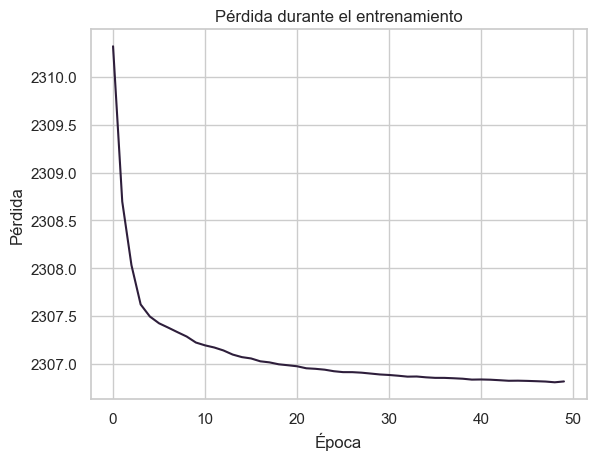

In [16]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

<div style="font-family: 'Garamond'; font-size: 14px;">
    
El gráfico muestra la disminución de la pérdida de un modelo de machine learning a lo largo del entrenamiento, indicando que el modelo está aprendiendo y mejorando su precisión con cada época. La pérdida inicial es de aproximadamente 1214 y parece estabilizarse justo por encima de 1206, lo que sugiere una convergencia hacia una solución pero también plantea la pregunta de si podría lograrse una mejora adicional con más ajustes, en este caso por falta de experiencia con redes neuronales no es posible. 

In [17]:
# Convertir el DataFrame de Spark a un array NumPy
encoded_features_array = np.array(encoded_features_df.select("encoded_features").rdd.map(lambda x: x.encoded_features.toArray()).collect())

<div style="font-family: 'Garamond'; font-size: 14px;">

Primero, se crea un nuevo modelo llamado `encoded_features_model`, que se basa en el modelo original del autoencoder. Sin embargo, este nuevo modelo está diseñado para tomar las mismas entradas que el modelo original, pero produce las salidas de la capa de codificación. Es decir, toma los datos de entrada y genera las representaciones codificadas de esos datos. Estas representaciones codificadas se almacenan en la variable `encoded_features`.

A continuación, las representaciones codificadas se convierten en un formato adecuado para trabajar con Spark. Inicialmente, están en forma de una estructura de datos NumPy, pero se convierten en un RDD (Resilient Distributed Dataset) de Spark utilizando `spark.sparkContext.parallelize`. Luego, se mapean para crear un DataFrame de Spark llamado `encoded_features_df`. Esto es útil para integrar las representaciones codificadas en el entorno de Spark, lo que permite realizar análisis posteriores o procesamientos de datos con Spark.

El código también realiza un entrenamiento adicional del autoencoder durante 50 épocas con un tamaño de lote de 64. Aunque el autoencoder ya se entrenó previamente, este paso podría ser útil para afinar aún más el modelo o verificar su estabilidad después de obtener las representaciones codificadas.

Luego, se imprime un resumen de las métricas de entrenamiento, que generalmente incluyen información sobre la pérdida (loss) en cada época. Esto proporciona una visión general de cómo el modelo está convergiendo y mejorando su capacidad para representar los datos de manera eficiente.

Además, se crea un gráfico utilizando la biblioteca Matplotlib que visualiza cómo cambió la pérdida durante las épocas de entrenamiento. Este gráfico ayuda a evaluar la convergencia del modelo y su capacidad para reducir la pérdida a medida que se ajusta a los datos.

Finalmente, las representaciones codificadas se extraen del DataFrame de Spark y se convierten nuevamente en un array NumPy llamado `encoded_features_array`. Esto puede ser útil si se necesita utilizar las representaciones codificadas en operaciones posteriores que requieran NumPy en lugar de Spark. En resumen, este código facilita la obtención y el manejo de las representaciones codificadas generadas por el autoencoder después del entrenamiento.

<div style="font-family: 'Garamond'; font-size: 14px;">
    
# KMEANS

<div style="font-family: 'Garamond'; font-size: 14px;">
  
K-Means es un algoritmo de aprendizaje automático no supervisado utilizado en análisis de datos y minería de datos para agrupar datos en clusters o grupos basados en similitudes. El objetivo principal del algoritmo K-Means es dividir un conjunto de datos en K grupos, donde K es un número predefinido de clusters que el usuario especifica antes de ejecutar el algoritmo. Cada cluster contiene puntos de datos que son más similares entre sí que con los puntos en otros clusters.

El algoritmo K-Means funciona de la siguiente manera:

1. Inicialización: Se seleccionan aleatoriamente K puntos de datos como centroides iniciales. Estos centroides representan el centro de cada cluster.

2. Asignación de puntos a clusters: Para cada punto de datos en el conjunto de datos, se calcula la distancia entre el punto y cada uno de los centroides. El punto se asigna al cluster cuyo centroide está más cerca de él.

3. Actualización de centroides: Una vez que todos los puntos han sido asignados a clusters, se recalcula el centroide de cada cluster tomando la media de todos los puntos asignados a ese cluster.

4. Repetición de pasos 2 y 3: Los pasos 2 y 3 se repiten iterativamente hasta que los centroides de los clusters ya no cambien significativamente o se alcance un número máximo de iteraciones predefinido.

El resultado final del algoritmo K-Means es un conjunto de K clusters, cada uno con un centroide que representa el punto central del cluster. Este algoritmo es útil para diversas aplicaciones, como segmentación de clientes, comprensión de patrones en datos y reducción de dimensionalidad.

Es importante destacar que K-Means es sensible a la inicialización de los centroides, lo que significa que diferentes selecciones iniciales de centroides pueden conducir a soluciones de agrupamiento diferentes. Por lo tanto, en la práctica, a menudo se realizan múltiples ejecuciones del algoritmo con diferentes inicializaciones y se selecciona la mejor solución en función de algún criterio, como la suma de las distancias al cuadrado dentro del cluster (inertia) o la silueta de los clusters. los clusters.

<div style="font-family: 'Garamond'; font-size: 14px;">

## Criterio del codo

El criterio del codo es una técnica comúnmente utilizada en análisis de clusters (clustering) para ayudar a determinar el número óptimo de clusters en un conjunto de datos. Su objetivo es identificar el punto en el que el incremento en la varianza explicada por los clusters adicionales se vuelve significativamente menor, lo que se asemeja a un "codo" en un gráfico. Este método es útil para tomar decisiones informadas sobre el número apropiado de clusters a utilizar en un algoritmo de agrupamiento, como K-Means.

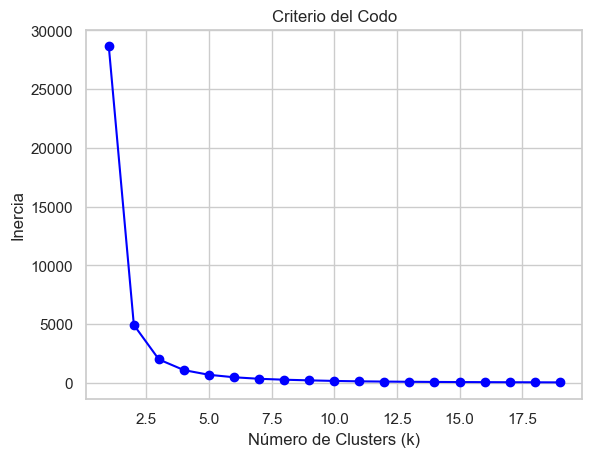

In [18]:
# Crear una lista vacía para almacenar las inercias
cs = []

# Probar diferentes valores de k (número de clusters)
for i in range(1, 20):
    kmeans = SKLearnKMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(encoded_features_array)  # Usar array Numpy de características codificadas

    # Calcular la inercia y añadirla a la lista
    cs.append(kmeans.inertia_)

# Trazar la curva de la inercia en función del número de clusters
plt.plot(range(1, 20), cs, marker='o', linestyle='-', color='blue')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Criterio del Codo')
plt.show()

<div style="font-family: 'Garamond'; font-size: 14px;">
    
## Reducción de dimensionalidad

In [19]:
# Asegurarse de que las características estén en formato de vector
assembler = VectorAssembler(inputCols=["encoded_features"], outputCol="features")
vectorized_df = assembler.transform(encoded_features_df)

# Estandarizar las características
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scalerModel = scaler.fit(vectorized_df)
scaled_df = scalerModel.transform(vectorized_df)

# Aplicar PCA
pca = PCA(k=3, inputCol="scaled_features", outputCol="pcaFeatures")
pcaModel = pca.fit(scaled_df)
result = pcaModel.transform(scaled_df)

<div style="font-family: 'Garamond'; font-size: 14px;">

En primer lugar, se utiliza un paso llamado `VectorAssembler` para asegurarse de que las características de los datos estén en un formato adecuado. Esto es importante porque muchas operaciones y modelos en PySpark requieren que las características se encuentren en un solo vector. El código utiliza `VectorAssembler` para combinar las columnas de entrada especificadas en un único vector llamado "features". El resultado de este paso se almacena en un nuevo DataFrame llamado `vectorized_df`.

A continuación, se aplica un proceso de estandarización a las características utilizando `StandardScaler`. La estandarización implica ajustar las características de manera que tengan una media de 0 y una desviación estándar de 1. Esto es útil para asegurarse de que todas las características estén en la misma escala y facilitar el procesamiento posterior. En este caso, `withStd=True` indica que se debe aplicar la desviación estándar, mientras que `withMean=False` indica que no se debe centrar las características en cero. El resultado se almacena en un DataFrame llamado `scaled_df`.

Después de la estandarización, se lleva a cabo el análisis de componentes principales (PCA). PCA es una técnica de reducción de dimensionalidad que busca encontrar las dimensiones más importantes o "componentes principales" en los datos. En este caso, el código configura PCA para retener únicamente las tress primeros componentes principales (`k=3`). Las características estandarizadas se utilizan como entrada, y el resultado se almacena en una nueva columna llamada "pcaFeatures" en el DataFrame `result`.

Finalmente, se aplica el modelo PCA al DataFrame estandarizado `scaled_df`, y el resultado se almacena en un nuevo DataFrame llamado `result`. Este último DataFrame contiene las características reducidas por PCA en la columna "pcaFeatures". Estas características representan la información más relevante y compacta de los datos originales en un espacio de menor dimensionalidad.

<div style="font-family: 'Garamond'; font-size: 14px;">

## Entrenamiento del algoritmo

In [20]:
# Crear el objeto KMeans
kmeans = KMeans(k=3, featuresCol="pcaFeatures", predictionCol="cluster")

# Entrenar el modelo KMeans
kmeans_model = kmeans.fit(result)

# Obtener las predicciones
predictions = kmeans_model.transform(result)

# Mostrar los resultados
predictions.select('pcaFeatures', 'cluster').show()

+--------------------+-------+
|         pcaFeatures|cluster|
+--------------------+-------+
|[-0.8387743653903...|      0|
|[-0.8437770993620...|      0|
|[-0.8662933357442...|      0|
|[-0.6991879126471...|      0|
|[-0.7413962720012...|      0|
|[-0.8595155296732...|      0|
|[-0.7433454379835...|      0|
|[-0.3006555686905...|      1|
|[-0.8371823277163...|      0|
|[-0.4796946220876...|      1|
|[-0.6791676385070...|      0|
|[-0.7908167473889...|      0|
|[-0.6440069893771...|      0|
|[-0.8662713586385...|      0|
|[-0.8529668602680...|      0|
|[-0.0141774868521...|      1|
|[-0.8637837610179...|      0|
|[0.44119952167283...|      1|
|[-0.8498488621423...|      0|
|[-0.8416284687883...|      0|
+--------------------+-------+
only showing top 20 rows



<div style="font-family: 'Garamond'; font-size: 14px;">

Dado un conjunto de datos $X = \{x_1, x_2, \ldots, x_n\}$ donde $x_i$ representa un punto de datos en un espacio $d$-dimensional, y deseamos dividirlos en $K$ clusters:

1\. Inicialización de centroides: Seleccionamos aleatoriamente $K$ centroides iniciales $\{\mu_1, \mu_2, \ldots, \mu_K\}$.

2\. Asignación de puntos a clusters: Para cada punto $x_i$, calculamos la distancia euclidiana entre $x_i$ y cada centroide $\mu_j$:

$$d(x_i, \mu_j) = \sqrt{\sum_{k=1}^{d}(x_{ik} - \mu_{jk})^2}$$

Asignamos $x_i$ al cluster cuyo centroide tiene la distancia más pequeña:

$$c_i = \arg\min_{j} d(x_i, \mu_j)$$

Donde $c_i$ representa el índice del cluster al que se asigna $x_i$.

3\. Actualización de centroides: Calculamos nuevos centroides para cada cluster tomando la media de todos los puntos asignados a ese cluster:

$$\mu_j = \frac{1}{|C_j|} \sum_{i \in C_j} x_i$$

Donde $|C_j|$ representa el número de puntos en el cluster $j$.

4\. Repetición de pasos 2 y 3: Los pasos 2 y 3 se repiten iterativamente hasta que se cumple un criterio de detención, como cuando los centroides ya no cambian significativamente o se alcanza un número máximo iteraciones. 

El objetivo del algoritmo K-Means es minimizar la función de costo, que se define como la suma de las distancias al cuadrado dentro de los clusters:

$$J = \sum_{j=1}^{K} \sum_{i \in C_j} d(x_i, \mu_j)^2$$

En resumen, el K-Means busca encontrar $K$ centroides que minimicen esta función de costo ajustando los centroides y asignando puntos de datos a clusters de manera iterativa. El resultado final es un conjunto de clusters donde cada punto de datos está asignado al cluster cuyo centroide es el más cercano en términos de distancia euclidiana.


In [21]:
# Coeficiente de silueta
evaluator = ClusteringEvaluator(predictionCol="cluster")
silhouette = evaluator.evaluate(predictions)
print("Coeficiente de silueta:", silhouette)

# Puntuación de Calinski-Harabasz
calinski_harabasz = evaluator.evaluate(predictions, {evaluator.metricName: "silhouette"})
print("Puntuación de Calinski-Harabasz:", calinski_harabasz)

Coeficiente de silueta: 0.7581121284643393
Puntuación de Calinski-Harabasz: 0.7581121284643393


<div style="font-family: 'Garamond'; font-size: 14px;">
    
El "Coeficiente de Silueta" (Silhouette Score) es una métrica que evalúa la cohesión y separación de los clústeres obtenidos. Esta métrica asigna a cada punto de datos un valor que indica cuán similar es ese punto a los demás puntos en su mismo clúster en comparación con los puntos en clústeres vecinos. Los valores del coeficiente de silueta oscilan entre -1 y 1, donde un valor alto (cerca de 1) indica una buena calidad de clustering con clústeres bien definidos y separados, mientras que un valor bajo (cerca de -1) sugiere que los clústeres se superponen o están mal definidos. En el código, se utiliza el evaluador `ClusteringEvaluator` para calcular el coeficiente de silueta a partir de las predicciones del modelo de clustering, y el resultado se almacena en la variable `silhouette`.

Por otro lado, la "Puntuación de Calinski-Harabasz" (Calinski-Harabasz Score) es otra métrica que evalúa la calidad de los clústeres formados por un algoritmo de clustering. Esta métrica mide la relación entre la dispersión interna de los clústeres y la dispersión entre clústeres. Un valor alto de la puntuación de Calinski-Harabasz indica que los clústeres son compactos y bien separados. En el código, se configura el evaluador `ClusteringEvaluator` con el parámetro `metricName` establecido en "silhouette" para calcular la puntuación de Calinski-Harabasz en lugar del coeficiente de silueta, y el resultado se almacena en la variable `calinski_harabasz`.

Ambas métricas son útiles para determinar la adecuación de la agrupación en clústeres y seleccionar el número óptimo de clústeres en un problema de clustering. En este caso, un coeficiente de silueta de 0.7581 sugiere que la elección de clústeres es muy apropiada, ya que un valor más cercano a 1 indica que los clústeres son cohesivos y bien separados, lo que respalda la calidad de los resultados obtenidos por el modelo K-Means.